### **1. Setup**


#### **1.1 imports and seed**

In [ ]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"eyalstyskin","key":"a55c5e9f10e98eda4ad48cb4e12d0f52"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

In [ ]:
# this is used just to list and find the wanted dataset for the next step
# !kaggle datasets list -s {fish-species-image-data}

In [ ]:
!kaggle datasets download -d 'sripaadsrinivasan/fish-species-image-data' -p /content/kaggle/

100% 1.31G/1.31G [00:13<00:00, 136MB/s]
100% 1.31G/1.31G [00:13<00:00, 106MB/s]


In [ ]:
!unzip '/content/kaggle/fish-species-image-data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Fish_Data/images/numbered/463.png  
  inflating: Fish_Data/images/numbered/464.png  
  inflating: Fish_Data/images/numbered/465.png  
  inflating: Fish_Data/images/numbered/466.png  
  inflating: Fish_Data/images/numbered/467.png  
  inflating: Fish_Data/images/numbered/468.png  
  inflating: Fish_Data/images/numbered/469.png  
  inflating: Fish_Data/images/numbered/47.png  
  inflating: Fish_Data/images/numbered/470.png  
  inflating: Fish_Data/images/numbered/471.png  
  inflating: Fish_Data/images/numbered/472.png  
  inflating: Fish_Data/images/numbered/473.png  
  inflating: Fish_Data/images/numbered/474.png  
  inflating: Fish_Data/images/numbered/475.png  
  inflating: Fish_Data/images/numbered/476.png  
  inflating: Fish_Data/images/numbered/477.png  
  inflating: Fish_Data/images/numbered/478.png  
  inflating: Fish_Data/images/numbered/479.png  
  inflating: Fish_Data/images/numbered/48.png  
  inflating: Fish_Da

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
# manualSeed = 999 # use if you want same results
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed) 
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  3095


#### **1.2 Load the data**

In [ ]:
# Root directory for dataset
dataroot = "/content/Fish_Data/images"

# Number of workers for dataloader
workers = 2

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# We can use an image folder dataset the way we have it setup.
# Create the dataset, 
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                              #squeezing for better results
                               transforms.Resize((image_size,image_size)),
                              #  transforms.CenterCrop(image_size),  
                              #  transforms.FiveCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#### **1.3(Optional) Plot some training images**


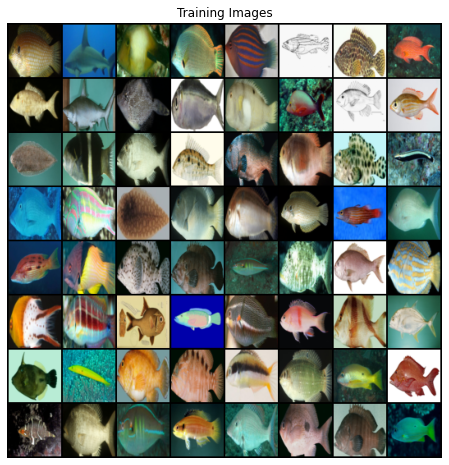

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### **2 Simple Vanilla GAN**


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### **2.1 Generator**

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()
    # Declare layers for the model
    self.fc1 = nn.Linear(input_size, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, 2 * hidden_dim)
    self.fc3 = nn.Linear(2 * hidden_dim, 4 * hidden_dim)
    self.fc4 = nn.Linear(4 * hidden_dim, output_size)
    pass

  def forward(self, x): 
    # Forward pass through the network
    x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
    x = F.dropout(x, p=0.3)
    x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
    x = F.dropout(x, p=0.3)
    x = F.leaky_relu(self.fc3(x), negative_slope=0.2)
    x = F.dropout(x, p=0.3)
    out = F.hardtanh(self.fc4(x))
    return out

Set hyper parameters:

In [ ]:
# generator hyper parameters
latent_vector_size = 100
first_hidden_size = 32
output_image_size = dataset[0][0].shape[1] * dataset[0][0].shape[2] * 3 #64*64*3=12288

# creates a generator
generator = Generator(latent_vector_size, first_hidden_size, output_image_size)

In [ ]:
print(generator)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=12288, bias=True)
)


In [ ]:
def create_latent_batch_vectors(batch_size, latent_vector_size, device):
  '''
  The function creates a random batch of latent vectors with random values 
  distributed uniformly between -1 and 1. 
  Finally, it moves the tensor to the given ```device``` (cpu or gpu).
  The output should have a shape of [batch_size, latent_vector_size].
  '''
  z = (-2 * torch.rand(batch_size, latent_vector_size, device=device)) + 1
  return z.to(device)

#### **2.2 Discriminator**

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()
    # Declare layers for the model
    self.fc1 = nn.Linear(input_size, 4 * hidden_dim)
    self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
    self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, output_size)
    pass
        
        
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
    x = F.dropout(x, p=0.3)
    x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
    x = F.dropout(x, p=0.3)
    x = F.leaky_relu(self.fc3(x), negative_slope=0.2)
    x = F.dropout(x, p=0.3)
    out = F.sigmoid(self.fc4(x))
    return out

Set hyper parameters:

In [ ]:
# discriminator hyper parameters
input_units = dataset[0][0].shape[1] * dataset[0][0].shape[2] * 3 #3*64*64=12288
last_hidden_size = 32
output_classification_size = 1

print("input_units: " + str(input_units))
# creates a discriminator
discriminator = Discriminator(input_units, last_hidden_size, output_classification_size)

input_units: 12288


In [ ]:
print(discriminator)

Discriminator(
  (fc1): Linear(in_features=12288, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
def create_labels(batch_size, device, real_data=True, for_discriminator=True):
  '''
  The function returns a batch_size-tensor with the correct labels.
  It creates labels according to the ```real_data``` and ```for_discriminator``` parameters.
  ```real_data``` - True if the batch images are real, and False for fake images
  ```for_discriminator``` - True if the labels should be created for the discriminator loss,
                            and False for the generator loss (False)
  If ```for_discriminator``` is set to True, it returns labels with smoothing,
  otherwise, it creates labels for the generator without smoothing.
  Finally, it moves the label tensors to the specified ```device```
  '''
  res = torch.zeros(batch_size,1)

  if not real_data and not for_discriminator:
    res = torch.ones(batch_size,1)
    
  if real_data and for_discriminator:
    res = torch.full(batch_size, 0.9)

  return res.to(device)


  res = torch.ones(batch_size,1)

  if for_doscriminator:
    if real_data: 
      res = torch.full(batch_size,0.9)
    else:
      res = torch.zeros(batch_size,1)
  else:
    if not real_data:
      res = torch.ones(batch_size,1)


#### **2.3 Train Loop**

In [ ]:
def gan_loss(discriminator_preds, labels):
    criterion = nn.BCELoss()
    loss = criterion(discriminator_preds.squeeze(), labels)
    return loss

In [ ]:
def train_gan(generator, discriminator, train_loader, lr = 0.002,
              latent_vector_size=100, nepochs=50, print_freq=400, device="cuda"):
  '''
  The function trains a gan model.
  '''
  
  # move models to device
  discriminator = discriminator.to(device)
  generator = generator.to(device)

  # Create optimizers for the discriminator and generator
  #   each optimizes different model
  d_optimizer = optim.Adam(discriminator.parameters(), lr)
  g_optimizer = optim.Adam(generator.parameters(), lr)

  # Track loss history
  losses = []


  # Create latent vectors that are held constant throughout training
  # This allows us to check the generator performance during training
  fixed_latent_batch = create_latent_batch_vectors(18, latent_vector_size, device)
  img_list = []

  # strat train loop
  for epoch in range(nepochs):
  
      # set both networks to train mode
      discriminator.train()
      generator.train()
      

      for batch_i, (real_images, _) in enumerate(train_loader):
          # rescale images before training
          real_images = (real_images*2 - 1).to(device)

          # get batch size
          batch_size = real_images.size(0)
 
          ######### A. TRAIN THE DISCRIMINATOR #########
 
          d_optimizer.zero_grad()
          real_label = torch.autograd.Variable(torch.Tensor(batch_size).fill_(1.0), requires_grad=False).to(device)
          fake_label = torch.autograd.Variable(torch.Tensor(batch_size).fill_(0.0), requires_grad=False).to(device)

          real_imgs = real_images.view(batch_size, -1)
          

          # 1. Compute the discriminator loss on real images
          real_loss = gan_loss(discriminator(real_imgs), real_label)
          # 2. Generate fake images using the generator (use ```create_latent_batch_vectors```)
          latent_vectors = create_latent_batch_vectors(batch_size, latent_vector_size, device)
          generated_fake_images = generator(latent_vectors)
          # 3. Compute the discriminator loss on fake images        
          fake_loss = gan_loss(discriminator(generated_fake_images.detach()), fake_label)
          # 4. Calculate discriminator total loss and do backprop

          discriminator_loss = (real_loss + fake_loss) / 2
          discriminator_loss.backward()
          d_optimizer.step()
          
          ######### B. TRAIN THE GENERATOR #########
          g_optimizer.zero_grad()

          # 1. Generate fake images
          latent_vectors = create_latent_batch_vectors(batch_size, latent_vector_size, device)
          generated_fake_images = generator(latent_vectors)
          # 2. Compute the discriminator loss on them but with flipped labels.
          generator_loss = gan_loss(discriminator(generated_fake_images), real_label)
          # 3. perform backprop
          generator_loss.backward()
          ######################
          g_optimizer.step()

          # Print some loss stats
          if batch_i % print_freq == 0:
              # print discriminator and generator loss
              print(f'Epoch {epoch}, Batch {batch_i}, Disc_loss: {discriminator_loss.item()}, Gen_loss: {generator_loss.item()}')

      # keep track of losses
      losses.append((discriminator_loss.item(), generator_loss.item()))

      # generate and save fixed sample for performance evaluation
      generator.eval()
      with torch.no_grad():
        fixed_sample = (generator(fixed_latent_batch)).detach().cpu()
      img_list.append(vutils.make_grid(fixed_sample, padding=2, normalize=True))
      #img_list.append(generator(fixed_latent_batch))


  return losses, img_list

In [ ]:
# hyperparmeters
nepochs = 10 # change to 50 when you think your implementation is correct
lr = 0.002
latent_vector_size = 100

In [ ]:
# create new generator and discriminator models
generator = Generator(latent_vector_size, first_hidden_size, output_image_size)
discriminator = Discriminator(input_units, last_hidden_size, output_classification_size)

# run the training process
loss_history,img_list = train_gan(generator, discriminator, dataloader, lr=lr,
          latent_vector_size=latent_vector_size, nepochs=nepochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0, Batch 0, Disc_loss: 0.6857011318206787, Gen_loss: 0.6376712918281555
Epoch 1, Batch 0, Disc_loss: 0.22712811827659607, Gen_loss: 2.974226236343384
Epoch 2, Batch 0, Disc_loss: 0.34058111906051636, Gen_loss: 3.100648880004883
Epoch 3, Batch 0, Disc_loss: 0.3677494525909424, Gen_loss: 1.7178306579589844
Epoch 4, Batch 0, Disc_loss: 0.30883315205574036, Gen_loss: 1.1234380006790161
Epoch 5, Batch 0, Disc_loss: 0.36865735054016113, Gen_loss: 1.3572015762329102
Epoch 6, Batch 0, Disc_loss: 0.211244136095047, Gen_loss: 1.989525556564331
Epoch 7, Batch 0, Disc_loss: 0.2273748219013214, Gen_loss: 2.262932777404785
Epoch 8, Batch 0, Disc_loss: 0.08155039697885513, Gen_loss: 3.1787452697753906
Epoch 9, Batch 0, Disc_loss: 0.24209007620811462, Gen_loss: 2.1022229194641113


In [ ]:
 #save models to drive/disk
 torch.save(generator, "generator.pth")
 torch.save(discriminator, "discriminator.pth")
 torch.save(loss_history, "loss_history.pth")

In [ ]:
 #load model
 generator = torch.load("generator.pth")
 discriminator = torch.load("discriminator.pth")
 loss_history = torch.load("loss_history.pth")

Let's plot the loss as a function of #epochs:

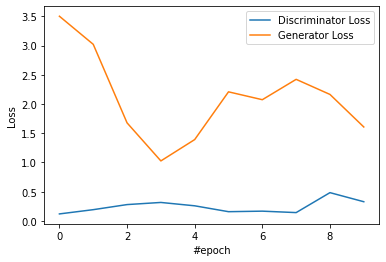

In [ ]:
loss_history = np.array(loss_history)
plt.plot(loss_history.T[0], label='Discriminator Loss')
plt.plot(loss_history.T[1], label='Generator Loss')
plt.ylabel("Loss")
plt.xlabel("#epoch")
plt.legend()

#### **2.4 Generating Images**

In [ ]:
def fixed_samples_grid(fixed_samples, nepochs):
  rows = int(nepochs / 5)
  cols = 3
  fig, axes = plt.subplots(figsize=(8,8), nrows=rows, ncols=cols, sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})
  # plt.subplots_adjust(wspace=0, hspace=0)
  for ax_row, sample in zip(axes, fixed_samples[::int(len(fixed_samples)/rows)]):
    for ax, img in zip(ax_row, sample[::int(len(sample)/cols)]):
      img = img.cpu().detach().numpy()
      ax.imshow(np.transpose(img[1].reshape(3,64,64),(1,2,0)))
      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)

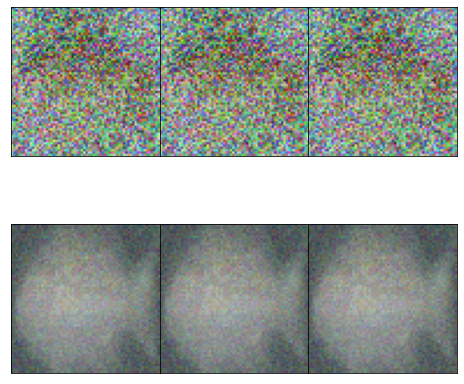

In [ ]:
fixed_samples_grid(img_list, nepochs)

### **3 Deep Convolutional GAN**


#### **3.1 defining the inputs**

In [ ]:

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5



#### **3.2 Generator**

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z with size 100
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [ ]:
print(Generator(1))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#### **3.3 Discriminator**

In [ ]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Creation and Initialization

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

#### **3.4 Train Loop**

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        iters += 1

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
    with torch.no_grad():
      fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))



In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### **3.4 Generating Images**

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())